# Clustering analysis
In this first notebook, we conduct a hierarchical clustering analysis on the whole brain and select clusters within an LFC mask. In other words, we cluster the *whole* brain, and then select clusters that we deem to be in LFC using a pre defined mask.

First lets import some basic necessities:

In [1]:
%matplotlib inline
import numpy as np
import joblib
import nibabel as nib
import seaborn as sns

#### Define what to cluster
I will use Neurosynth's `Clusterable` object to define which voxels to cluster (ROI), and which voxels to use as a *reference*. `Clusterable` takes care of loading data from the dataset for us, and allows us to specify how to select voxels.

First, we define our clustering ROI as the whole cortex (e.g. voxels with greatrer than 30% probability of grey matter according to the Harvard-Oxford atlas). Additionally, we want to exclude voxels activated by fewer than 100 voxels per studies as they lack sufficient signal.

Next, we define a `reference` set of voxels that we will use to calculate the co-activation between each voxel in our ROI and the rest of the brain. In order to include the whole brain including subcortex, I only exclude voxels with fewer than 100 studies.

In [2]:
from neurosynth.analysis.cluster import Clusterable
from neurosynth.base.dataset import Dataset
dataset = Dataset.load("data/neurosynth_60_0.6.pkl")

whole_cortex_roi = Clusterable(dataset, 'masks/cortex_30.nii.gz', min_studies=100)
reference = Clusterable(dataset, min_studies=100)

#### Reduce and cluster
To perform the clustering, we use ward hierarchical clustering from the `fastcluster` package– a highly efficient implementation of this computational costly algorithm. To reduce the computational demands, we also reduce the dimensionality of our reference voxels into 100 PCA components. `Clusterable` implements a transform method to make this easy.

Next, we calculate the correlation distance between each voxel in our cortical ROI and the rest of the brain (i.e. each PCA voxel), resulting in a ROI voxels by PCA components distance matrix. Next, I also take the optional step of scaling this co-activation matrix in order to ensure more even cluster sizes. Without scaling this matrix, voxels that have a greater activation rate tend to form smaller clusters than less frequently active voxels. 

Finally, we pass the final matrix to `ward()` to compute the hierarchical linkage matrix, `Z`. 

In [ ]:
from fastcluster import ward
from sklearn import decomposition as sk_decomp
from sklearn.preprocessing import scale

reduce_reference = sk_decomp.RandomizedPCA(100)
reference = reference.transform(reduce_reference, transpose=True)

distances = pairwise_distances(whole_cortex.data, reference.data, metric='correlation')
distances = scale(distances, axis=1)

Z = ward(distances)

Like a TV cooking show, I'm going to load a pickled copy of the linkage matrix I previously ran:

In [3]:
Z = joblib.load('data/whole_cortex_scaled.pkl')

#### Saving flat clusters
The linkage matrix Z describes the hierarchical clustering at every step. We can use `fcluster` to produce flat clusters at any dimensionality, such as 5 or 70 clusters. To get back into MNI space, we use the the `unmask` function of the `masker` attacked to `whole_cortex_roi`, and ask for a nifti image. 

To select clusters within LFC, we use the function `select_clusters` to return a nifti image only with clusters that fall into an apriori LFC mask. For the coarse 5 cluster solution, I only require clusters to have 10% of their voxels in LFC, while at the more fine-grained 70 cluster solution, I require clusters to have at least 75% of their voxels in the LFC mask to be included.

In [4]:
from scipy.cluster.hierarchy import fcluster
from utils import select_clusters

# Get flat clusers as niftis and save to disk
whole_brain_5 = whole_cortex_roi.masker.unmask(fcluster(Z, 5, 'maxclust'), output='image')
nib.save(whole_brain_5, 'images/wb_5.nii.gz')

whole_brain_70 = whole_cortex_roi.masker.unmask(fcluster(Z, 70, 'maxclust'), output='image')
nib.save(whole_brain_70, 'images/wb_70.nii.gz')

# Select clusters within LFC and save to disk
lfc_mask = nib.load('masks/lfc_mask.nii.gz')

_, lfc_5 = select_clusters(whole_brain_5, lfc_mask, amount=.14)
nib.save(lfc_5, 'images/lfc_5.nii.gz')

_, lfc_70 = select_clusters(whole_brain_70, lfc_mask, amount=.75)
nib.save(lfc_70, 'images/lfc_70.nii.gz')

## Whole brain clustering dendrogram
To visualize the whole brain clustering, I used an R library `dendextend` to generate a dendrogram from k=70 and above, and colored the branches by their grouping at k=5. Unfortunately, this library requires the clustering to be describes in R's format for hierarchical clustering, so I've included a saved version of the same clustering the correct format. 

In [5]:
%load_ext rpy2.ipython
from colors import l_5_colors, k_5_colors, l_70_colors # Colors used in the publication
from matplotlib.colors import rgb2hex 

l_5_colors_hex = [rgb2hex(col) for col in l_5_colors]
%Rpush l_5_colors_hex

In [ ]:
%%R
library(dendextend)
clust <- readRDS('data/whole_cortex_scaled.R')
dend <- as.dendrogram(clust)

In [ ]:
%%R -w 1000 -h 500
k_70_dend <- cut(dend, h=209)$upper
k_70_dend  %>% 
set("labels", c(1:71)) %>%
set("branches_col", c('grey')) %>%
set("branches_k_color", value = c("grey", "grey", l_5_colors_hex), k = 5) %>% 
set("branches_lwd", 4) %>%
hang.dendrogram(-1) %>%
set("labels", c("")) %>%
plot()
abline(h = 340, lty = 2)
abline(h = 600, lty = 2)

## Brain surface maps
Finally, to actually visualize on the brain what these clusters look like, I used `pysurfer` to render each cluster onto an inflated brain surface. The function `surf_clusters` does the heavy lifting for you, converting each clustering volume to a Freesurfer surface, and plots them with sensible defaults onto a pysurfer brain. 

In [6]:
%gui qt
from surfer import Brain
import os
os.environ['SUBJECTS_DIR'] = '/Applications/freesurfer/subjects/'
os.environ['FREESURFER_HOME'] = '/Applications/freesurfer/'
from IPython.display import Image
from plotting import surf_clusters

In [7]:
## Display parameters to be used across all visualizations, 
## including overall paramters, and specific ones for each hemisphere

brain_kwargs = {'size' : (820, 400), 'background' : 'white', 'views' : ['lat'], 'cortex' : 'bone'}

right_args = {'azimuth': 22, 'elevation': 86}
right_kwargs = {'distance' : 430, 'roll' : -90, 'col' : 1}

left_args = {'azimuth': 162, 'elevation': 86}
left_kwargs = {'distance' : 430, 'roll' : 90, 'col' : 0}

### 5-cluster 'network' solution
Here, I'm separately plotting the three clusters in LFC and all 5 clusters

In [8]:
brain = Brain('fsaverage', 'split', 'inflated', **brain_kwargs)

_ = surf_clusters(brain, lfc_5, colormap=l_5_colors)
brain.show_view(left_args, **left_kwargs)
brain.show_view(right_args, **right_kwargs)
brain.save_image('plots/lfc_networks.png')

mri_vol2surf --mov /var/folders/t3/_lfrdgjn4k5152_zgh5q65ym0000gp/T/tmpQ7c8m0.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/t3/_lfrdgjn4k5152_zgh5q65ym0000gp/T/pysurfer-v2sjhOREg.mgz
mri_vol2surf --mov /var/folders/t3/_lfrdgjn4k5152_zgh5q65ym0000gp/T/tmpQ7c8m0.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/t3/_lfrdgjn4k5152_zgh5q65ym0000gp/T/pysurfer-v2sS_10bL.mgz


/Users/alejandro/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/mayavi/tools/camera.py:288: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if focalpoint is not None and not focalpoint == 'auto':


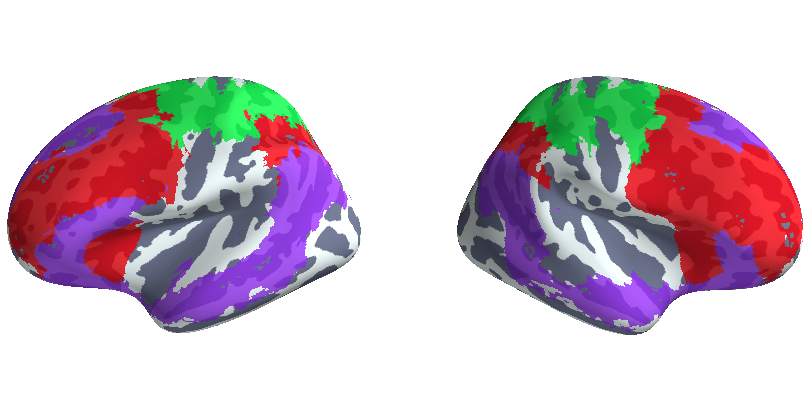

In [9]:
Image('plots/lfc_networks.png')

In [80]:
brain = Brain('fsaverage', 'split', 'inflated', **brain_kwargs)

# Note that 
_ = surf_clusters(brain, whole_brain_5, colormap=k_5_colors)
brain.show_view(left_args, **left_kwargs)
brain.show_view(right_args, **right_kwargs)
brain.save_image('plots/all_networks.png')

mri_vol2surf --mov /var/folders/t3/_lfrdgjn4k5152_zgh5q65ym0000gp/T/tmptUZL8Z.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/t3/_lfrdgjn4k5152_zgh5q65ym0000gp/T/pysurfer-v2sBg__mP.mgz
mri_vol2surf --mov /var/folders/t3/_lfrdgjn4k5152_zgh5q65ym0000gp/T/tmptUZL8Z.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/t3/_lfrdgjn4k5152_zgh5q65ym0000gp/T/pysurfer-v2sAfrtk6.mgz


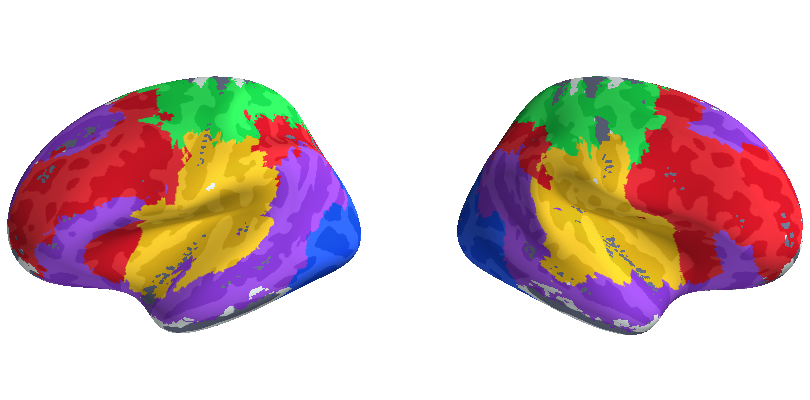

In [81]:
Image('plots/all_networks.png')

### 70-cluster 'sub-region' solution
Now for each of the groupings in the paper (or any we choose), we can plot sets of clusters. Note we use level_mask to define which clusters we want to plot, but we pass a full set of colors (i.e. 14). surf_clusters takes care of choosing the right colors for each cluster

In [13]:
%load_ext autoreload
%autoreload 1
%aimport plotting

mri_vol2surf --mov /var/folders/t3/_lfrdgjn4k5152_zgh5q65ym0000gp/T/tmpB_lePB.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/t3/_lfrdgjn4k5152_zgh5q65ym0000gp/T/pysurfer-v2szBM0JP.mgz
mri_vol2surf --mov /var/folders/t3/_lfrdgjn4k5152_zgh5q65ym0000gp/T/tmpB_lePB.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/t3/_lfrdgjn4k5152_zgh5q65ym0000gp/T/pysurfer-v2sgvDCjj.mgz


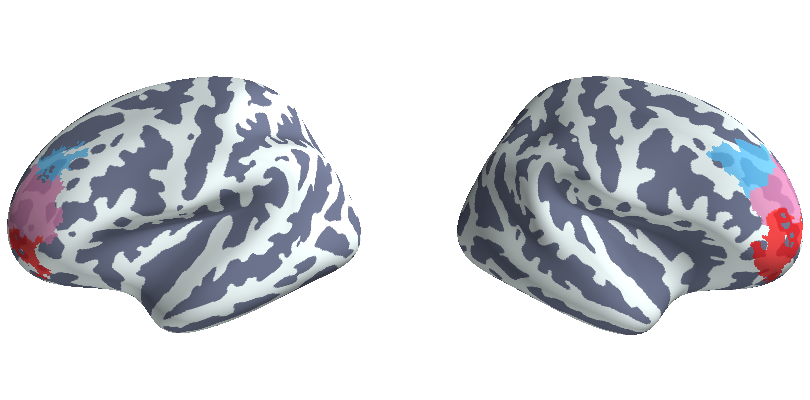

In [14]:
brain = Brain('fsaverage', 'split', 'inflated', **brain_kwargs)
_ = surf_clusters(brain, lfc_70, colormap=l_70_colors, level_mask=[3, 4, 5])

brain.show_view(left_args, **left_kwargs)
brain.show_view(right_args, **right_kwargs)
brain.save_image('plots/k_70_fp_regions.png')

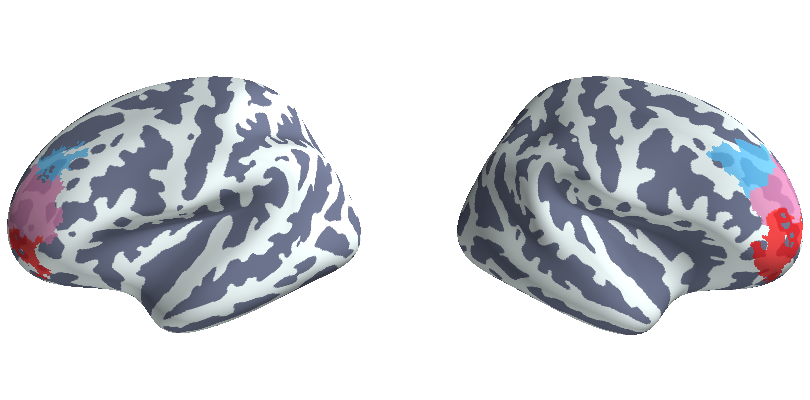

In [95]:
Image('plots/k_70_fp_regions.png')

In [21]:
brain = Brain('fsaverage', 'split', 'inflated', **brain_kwargs)
_ = plotting.surf_clusters(brain, lfc_70, colormap=l_70_colors, level_mask=[6, 7, 8, 9])

brain.show_view(left_args, **left_kwargs)
brain.show_view(right_args, **right_kwargs)
brain.save_image('plots/k_70_mid_regions.png')

mri_vol2surf --mov /var/folders/t3/_lfrdgjn4k5152_zgh5q65ym0000gp/T/tmpRuySz9.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/t3/_lfrdgjn4k5152_zgh5q65ym0000gp/T/pysurfer-v2sK5dWt_.mgz
mri_vol2surf --mov /var/folders/t3/_lfrdgjn4k5152_zgh5q65ym0000gp/T/tmpRuySz9.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/t3/_lfrdgjn4k5152_zgh5q65ym0000gp/T/pysurfer-v2sojO0Al.mgz


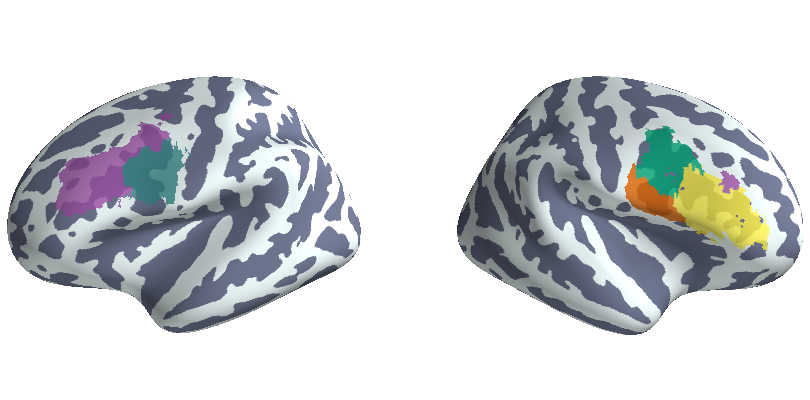

In [22]:
Image('plots/k_70_mid_regions.png')

In [23]:
brain = Brain('fsaverage', 'split', 'inflated', **brain_kwargs)
_ = surf_clusters(brain, lfc_70, colormap=l_70_colors, level_mask=[10, 11])

brain.show_view(left_args, **left_kwargs)
brain.show_view(right_args, **right_kwargs)
brain.save_image('plots/k_70_caud_regions.png')

mri_vol2surf --mov /var/folders/t3/_lfrdgjn4k5152_zgh5q65ym0000gp/T/tmpUQtRMF.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/t3/_lfrdgjn4k5152_zgh5q65ym0000gp/T/pysurfer-v2sSZqLO2.mgz
mri_vol2surf --mov /var/folders/t3/_lfrdgjn4k5152_zgh5q65ym0000gp/T/tmpUQtRMF.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/t3/_lfrdgjn4k5152_zgh5q65ym0000gp/T/pysurfer-v2snnKVoW.mgz


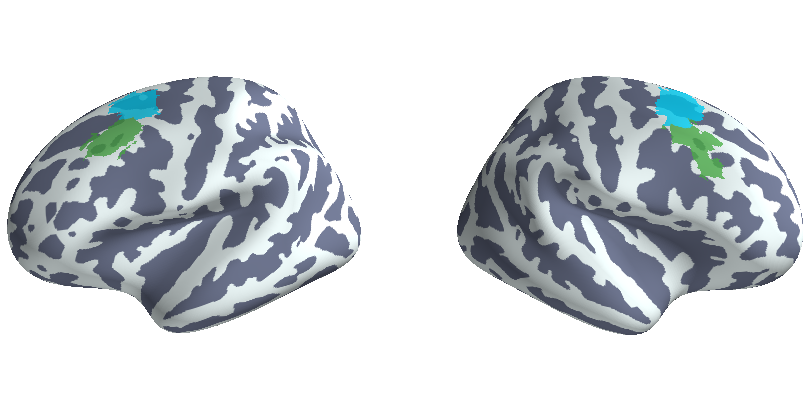

In [24]:
Image('plots/k_70_caud_regions.png')

In [25]:
brain = Brain('fsaverage', 'split', 'inflated', **brain_kwargs)
_ = surf_clusters(brain, lfc_70, colormap=l_70_colors, level_mask=[12, 13, 14])

brain.show_view(left_args, **left_kwargs)
brain.show_view(right_args, **right_kwargs)
brain.save_image('plots/k_70_default_regions.png')

mri_vol2surf --mov /var/folders/t3/_lfrdgjn4k5152_zgh5q65ym0000gp/T/tmp8R1Ku4.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/t3/_lfrdgjn4k5152_zgh5q65ym0000gp/T/pysurfer-v2s5w9tJ8.mgz
mri_vol2surf --mov /var/folders/t3/_lfrdgjn4k5152_zgh5q65ym0000gp/T/tmp8R1Ku4.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/t3/_lfrdgjn4k5152_zgh5q65ym0000gp/T/pysurfer-v2sqQK0Yq.mgz


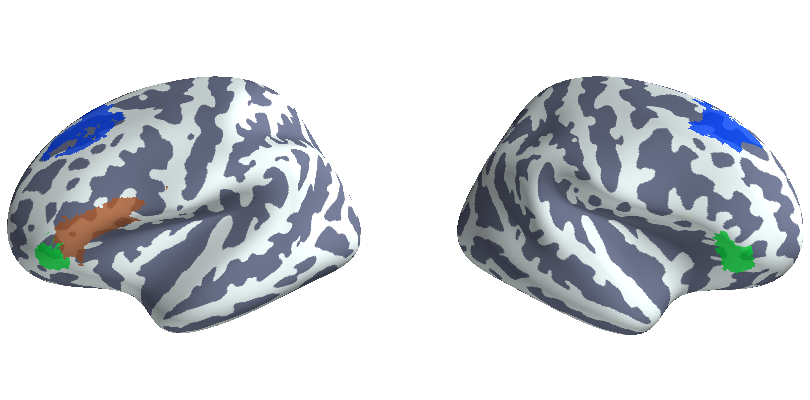

In [26]:
Image('plots/k_70_default_regions.png')

In [27]:
brain = Brain('fsaverage', 'split', 'inflated', **brain_kwargs)
_ = surf_clusters(brain, lfc_70, colormap=l_70_colors, level_mask=[1, 2])

brain.show_view(left_args, **left_kwargs)
brain.show_view(right_args, **right_kwargs)
brain.save_image('plots/k_70_motor_regions.png')

mri_vol2surf --mov /var/folders/t3/_lfrdgjn4k5152_zgh5q65ym0000gp/T/tmp6ibrYc.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/t3/_lfrdgjn4k5152_zgh5q65ym0000gp/T/pysurfer-v2s9bEj6i.mgz
mri_vol2surf --mov /var/folders/t3/_lfrdgjn4k5152_zgh5q65ym0000gp/T/tmp6ibrYc.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/t3/_lfrdgjn4k5152_zgh5q65ym0000gp/T/pysurfer-v2sRsd3mt.mgz


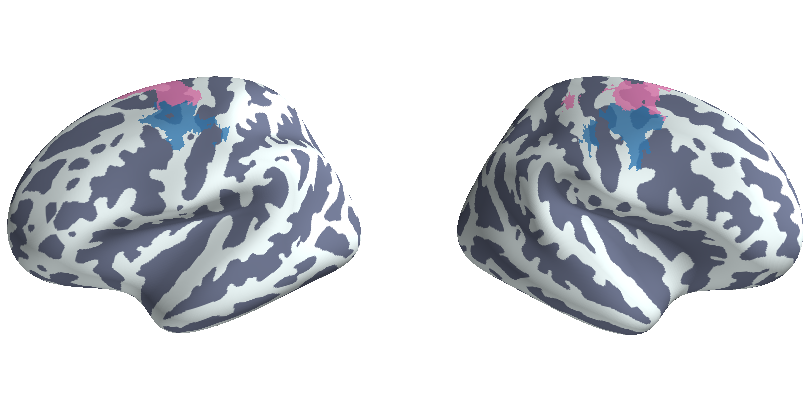

In [28]:
Image('plots/k_70_motor_regions.png')

Finally, we can also plot the whole brain clustering at k = 70, including all clusters 

In [133]:
brain = Brain('fsaverage', 'split', 'inflated', size = (820, 800), background = 'white', 
              views = ['med', 'lat'], cortex = 'bone')

_ = surf_clusters(brain, whole_brain_70)
brain.save_image('plots/whole_brain_k70_regions.png')

mri_vol2surf --mov /var/folders/t3/_lfrdgjn4k5152_zgh5q65ym0000gp/T/tmpw44qK1.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/t3/_lfrdgjn4k5152_zgh5q65ym0000gp/T/pysurfer-v2sRui6j4.mgz
mri_vol2surf --mov /var/folders/t3/_lfrdgjn4k5152_zgh5q65ym0000gp/T/tmpw44qK1.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/t3/_lfrdgjn4k5152_zgh5q65ym0000gp/T/pysurfer-v2sW64ypW.mgz


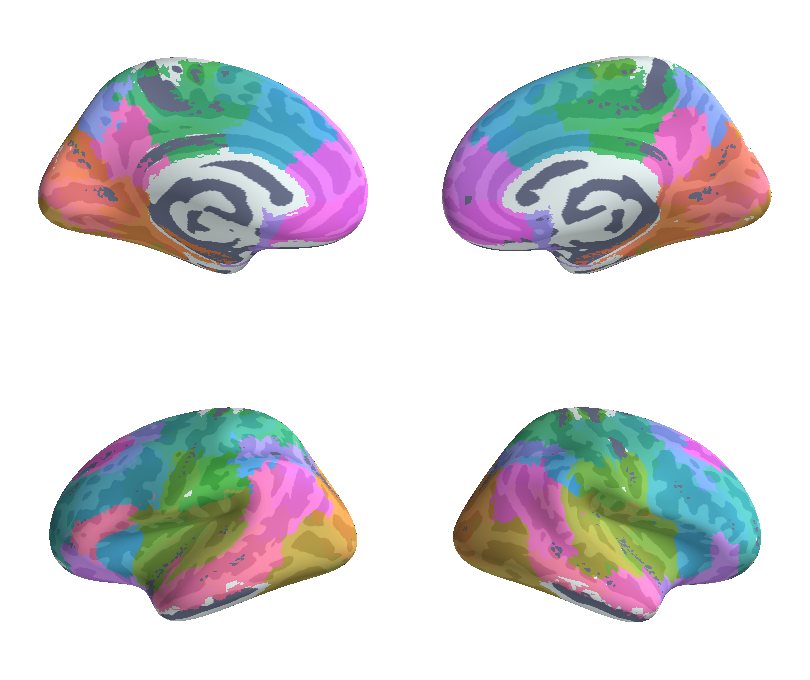

In [134]:
Image('plots/whole_brain_k70_regions.png')